In [1]:
import matplotlib
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import *

In [3]:
opposition = ['con','ld','ukip','grn','snp']
parties = ['lab'] + opposition

In [4]:
ge10, ge15, ge17 = read_in_election_results()
census           = read_in_census()

In [5]:
marginals        = calc_marginal_within(0.15,ge17)

In [6]:
# Combine latest election with census data 
ge17_census = ge17.merge(census.drop(columns=['Region','Constituency']),
                         left_index=True, right_index=True,validate='one_to_one')

demographics = ['c11PopulationDensity',
                'c11HouseOwned',
                'c11CarsNone',
                'c11EthnicityWhite',
                 'c11Unemployed',
                 'c11Retired',
                 'c11FulltimeStudent',
                 'c11Age65to74',
                 'c11DeprivedNone']

constit_demog = ge17_census[marginals][['Constituency']+demographics]
constit_demog.dropna(inplace=True)
constit_demog.head()

,Constituency,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,,
E14000532,Altrincham and Sale West,18.709288,74.080473,16.001903,90.433891,3.039963,14.139160,6.895702,8.780321,54.415484
E14000535,Ashfield,9.461836,69.088815,23.541067,97.957101,4.742731,17.086589,5.352682,9.957415,35.995853
E14000543,Barrow and Furness,3.156686,74.156604,26.699863,98.428388,4.202689,18.749525,5.211578,11.017045,39.920329
E14000546,Bassetlaw,2.164558,68.839905,20.918077,97.421201,4.016112,16.985105,5.781579,10.114827,39.784115
E14000549,Battersea,103.770227,41.996919,49.562901,73.483961,3.849259,5.621670,6.969718,4.469164,50.932479


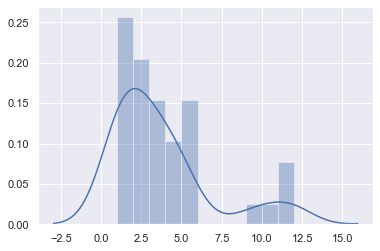

In [28]:
clusters, cluster_labels = cluster_constituencies_kmeans(40, constit_demog, demographics)

cluster_sizes = [len(x) for x in clusters.values()]
sns.distplot(cluster_sizes,bins=range(max(cluster_sizes)+1),norm_hist=False)

Converged after 20 iterations.
16


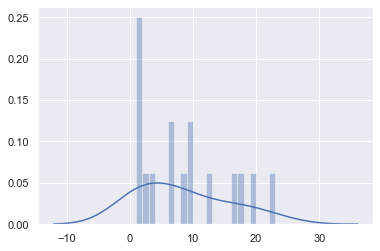

In [29]:
def get_clusters(names,labels):
    n_clusters = max(labels)
    clusters = {}
    for cluster in range(n_clusters):
        mask = labels == cluster
        similar = list(names[mask])
        clusters[cluster] = similar
    return clusters

from sklearn import cluster, covariance, manifold
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
X = constit_demog[demographics]
X_scaled = preprocessing.scale(X)

clustering = AffinityPropagation(verbose=True).fit(X)

clusters = get_clusters(constit_demog.index,clustering.labels_)
print(len(clusters))
cluster_sizes = [len(x) for x in clusters.values()]
sns.distplot(cluster_sizes,bins=range(max(cluster_sizes)+1),norm_hist=False)



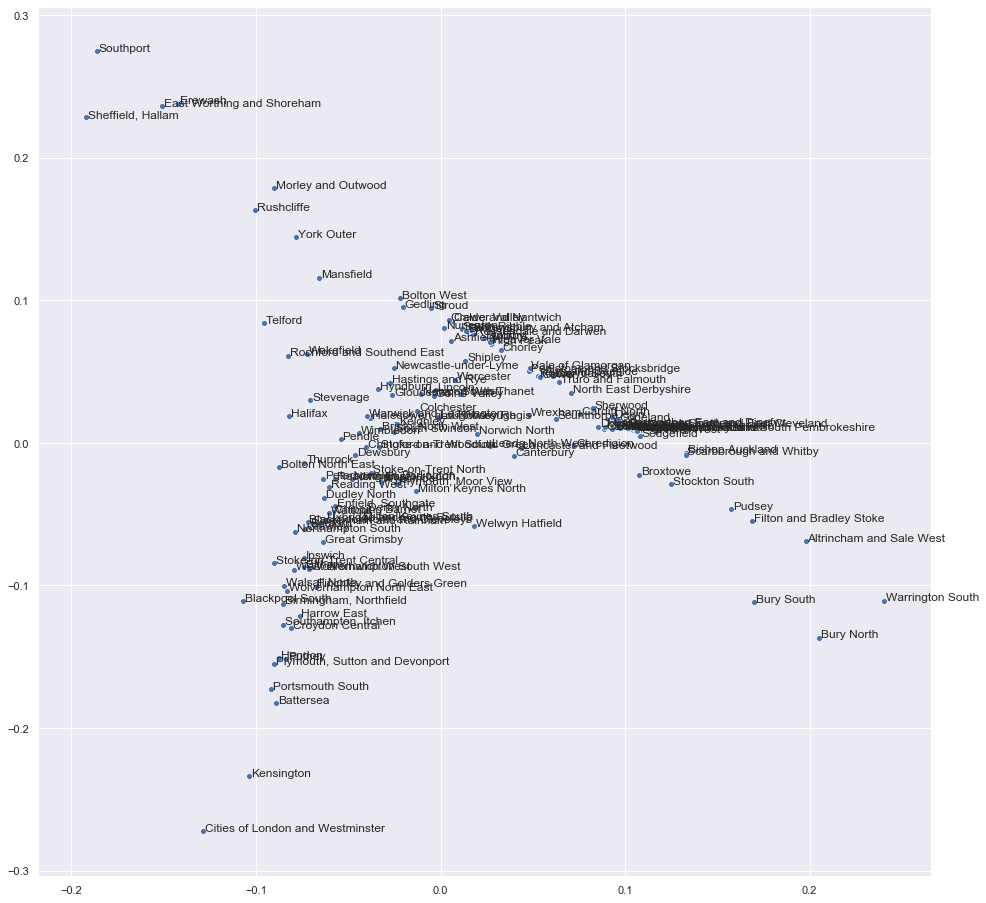

In [31]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

embedding = LocallyLinearEmbedding(n_components=2)
#embedding = Isomap(n_components=2)
#embedding = SpectralEmbedding(n_components=2)
#embedding = TSNE(n_components=2)

X_transformed = embedding.fit_transform(X)
X_transformed.shape
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])
val = pd.Series(constit_demog['Constituency'])
val.index=range(len(X_transformed))

plt.figure(figsize=(16, 16))
ax = sns.scatterplot(x=x,y=y)
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x']+.001, point['y'], str(point['val']))


In [10]:
# view the demographic data of any cluster, check they are somewhat similar 
constit_demog[cluster_labels == 18]

,Constituency,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,,
E14000532,Altrincham and Sale West,18.709288,74.080473,16.001903,90.433891,3.039963,14.139160,6.895702,8.780321,54.415484
E14000702,Filton and Bradley Stoke,11.478641,71.245436,14.366774,91.652546,2.895352,12.284420,9.929845,7.855285,51.149289
E14000886,Pudsey,16.343344,72.941543,19.631918,93.266558,3.043565,14.989020,6.282152,8.745709,50.911120
E14001018,Warrington South,11.992384,75.101685,16.430519,95.420268,3.546172,15.230826,6.329082,9.104331,51.010146
W07000051,Cardiff North,20.672537,74.883591,18.541754,90.876592,3.225056,13.176346,12.825763,7.789909,49.694688


In [23]:
# ### How good were the campaigns
# We need a measure of how succesful the last campaign was. Here I'm just making it the difference in votes from 2015 to 2017. Ideally we would use something like labour's own forecasting, or data on how much was invested in a campaign, or polls etc

# In[16]:
constituency_scores = score_campaigns_difference(ge17,ge15)
constit_demog[constit_demog.index=='E14000908']

,Constituency,c11PopulationDensity,c11HouseOwned,c11CarsNone,c11EthnicityWhite,c11Unemployed,c11Retired,c11FulltimeStudent,c11Age65to74,c11DeprivedNone
ons_id,,,,,,,,,,
E14000908,Rushcliffe,3.070021,76.40538,15.476342,92.488653,2.75817,15.607843,9.211329,9.348904,54.778673


In [26]:
constituency_scores['change'].values.reshape(-1,1)

array([[ 7.2460e+03],
       [ 5.1880e+03],
       [-3.6600e+02],
       [-3.8480e+03],
       [ 3.2190e+03],
       [-1.0120e+03],
       [ 7.0090e+03],
       [ 3.1750e+03],
       [ 7.0260e+03],
       [ 6.7750e+03],
       [ 1.7040e+03],
       [ 1.3140e+03],
       [ 3.3050e+03],
       [ 6.5000e+02],
       [ 7.3660e+03],
       [ 1.8370e+03],
       [ 7.2600e+03],
       [ 4.6390e+03],
       [ 9.2660e+03],
       [-3.2030e+03],
       [-1.6480e+03],
       [-2.0280e+03],
       [ 8.6350e+03],
       [ 1.2890e+03],
       [ 7.4930e+03],
       [ 4.6060e+03],
       [ 3.2010e+03],
       [ 4.2720e+03],
       [ 3.7950e+03],
       [ 3.8280e+03],
       [ 5.3380e+03],
       [ 3.5020e+03],
       [ 1.0630e+03],
       [ 8.0180e+03],
       [ 6.5000e+03],
       [ 5.9420e+03],
       [ 6.0610e+03],
       [ 4.1840e+03],
       [ 8.7360e+03],
       [ 9.0300e+03],
       [ 8.3940e+03],
       [ 9.0150e+03],
       [ 4.3220e+03],
       [ 1.8190e+03],
       [ 1.0582e+04],
       [ 5

In [12]:
# make a useful database `data`, that calculates the how good the campaign was relevant to the others in the cluster. Basically trying to remove the naitonal campaign so we can figure out which local campaigns did well.

# In[17]:

cluster_summary = gather_data(clusters, constituency_scores, ge17)
cluster_summary.head()
cluster_summary.sort_values(by='dist_from_mean',ascending=False)
cluster_summary.loc[1,'ons_id']

'E14000546'

In [13]:
ge17_cluster = ge17.merge(cluster_summary.rename(columns={'constituency':'Constituency'}),on="Constituency")

cols = ['Constituency','marginal','sigma_from_mean','dist_from_mean','change',
        'cluster','cluster_size','winner','con','lab','ld','snp']
ge17_cluster[cols].sort_values(by='dist_from_mean',ascending=False).head(5)

best_labour_campaigns = ge17_cluster[cols].sort_values(by='dist_from_mean',ascending=False).head(10)['Constituency'].values
best_labour_campaigns



def find_worst_similar_constit(best,cluster_summary):
    cluster = int(cluster_summary['cluster'][cluster_summary['constituency']==best])
    clusterdata = cluster_summary[cluster_summary['cluster']==cluster]
    smallest_swing = clusterdata['change'].idxmin()
    return cluster_summary['constituency'].loc[smallest_swing]

for i in range(len(best_labour_campaigns)):
    print(best_labour_campaigns[i],',',find_worst_similar_constit(best_labour_campaigns[i],cluster_summary))

Truro and Falmouth , Dwyfor Meirionnydd
Canterbury , Ceredigion
Plymouth, Sutton and Devonport , Walsall North
East Worthing and Shoreham , Nuneaton
Camborne and Redruth , Dwyfor Meirionnydd
Colchester , Thurrock
Milton Keynes North , Thurrock
Reading East , Wolverhampton South West
Milton Keynes South , Thurrock
Croydon Central , Finchley and Golders Green


In [14]:
cluster_summary.sort_values(by='dist_from_mean',ascending=False)

,ons_id,constituency,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean,pos_in_cluster
11,E14001003,Truro and Falmouth,0,23,5391.478261,2424.716781,13517.0,3.351122,8125.521739,1.000000
52,E14000619,Canterbury,4,6,7329.833333,2529.617851,12452.0,2.024878,5122.166667,1.000000
28,E14000880,"Plymouth, Sutton and Devonport",2,9,4925.888889,2262.206221,9686.0,2.104190,4760.111111,1.000000
39,E14000682,East Worthing and Shoreham,3,19,6529.684211,1730.832019,11145.0,2.666530,4615.315789,1.000000
3,E14000616,Camborne and Redruth,0,23,5391.478261,2424.716781,9976.0,1.890745,4584.521739,0.954545
123,E14000644,Colchester,15,12,7095.500000,2525.303332,11036.0,1.560407,3940.500000,1.000000
125,E14000821,Milton Keynes North,15,12,7095.500000,2525.303332,10901.0,1.506948,3805.500000,0.909091
104,E14000889,Reading East,10,8,7363.000000,2077.532671,10396.0,1.459905,3033.000000,1.000000
126,E14000822,Milton Keynes South,15,12,7095.500000,2525.303332,10058.0,1.173126,2962.500000,0.818182
75,E14000654,Croydon Central,7,3,4485.333333,1996.458921,7285.0,1.402316,2799.666667,1.000000


In [15]:
# From the above data, the best campaigns are in quite large clusters, so hard to pick out all the information. Milton Keynes South performed well, and is in a small cluster so I've chosen that as an example.
# 
# ## Is this useful???
# 
# Declare the cluster you are interested in and the following cells will make some useful stats on it...
# 
# All the constituencies in the group improved their votes for labour, but by varying amounts.

cluster = 10

In [16]:
cluster_summary[cluster_summary['cluster']==cluster].sort_values(by='dist_from_mean',ascending=False)

,ons_id,constituency,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean,pos_in_cluster
104,E14000889,Reading East,10,8,7363.0,2077.532671,10396.0,1.459905,3033.0,1.000000
106,E14001021,Watford,10,8,7363.0,2077.532671,10033.0,1.285178,2670.0,0.857143
101,E14000634,Chingford and Woodford Green,10,8,7363.0,2077.532671,8025.0,0.318647,662.0,0.714286
102,E14000636,Chipping Barnet,10,8,7363.0,2077.532671,7223.0,-0.067388,-140.0,0.571429
103,E14000692,"Enfield, Southgate",10,8,7363.0,2077.532671,7118.0,-0.117928,-245.0,0.428571
105,E14001007,Uxbridge and South Ruislip,10,8,7363.0,2077.532671,6866.0,-0.239226,-497.0,0.285714
107,E14001040,Wimbledon,10,8,7363.0,2077.532671,5718.0,-0.791805,-1645.0,0.142857
108,E14001051,Wolverhampton South West,10,8,7363.0,2077.532671,3525.0,-1.847384,-3838.0,0.000000


In [17]:
ge17_cluster[ge17_cluster['cluster']==cluster].sort_values(by='dist_from_mean',ascending=False)

,PANO,Constituency,Surname,First name,Party,Party Identifer,Valid votes,total_votes,ukip,ukip_pc,ld,ld_pc,lab,lab_pc,con,con_pc,snp,snp_pc,grn,grn_pc,winner,second,third,marginal,ons_id,cluster,cluster_size,mean,std,change,sigma_from_mean,dist_from_mean,pos_in_cluster
74,464,Reading East,RODDA,Matthew Richard Allen,Labour Party,Labour,27093,55238,0.0,0.000000,3378.0,0.061154,27093.0,0.490478,23344.0,0.422608,0.0,0.0,1093.0,0.019787,lab,con,ld,True,E14000889,10,8,7363.0,2077.532671,10396.0,1.459905,3033.0,1.000000
105,604,Watford,OSTROWSKI,Christopher Michael,Labour Party,Labour,24639,58610,1184.0,0.020201,5335.0,0.091025,24639.0,0.420389,26731.0,0.456083,0.0,0.0,721.0,0.012302,con,lab,ld,True,E14001021,10,8,7363.0,2077.532671,10033.0,1.285178,2670.0,0.857143
20,146,Chingford and Woodford Green,MAHMOOD,Bilal,The Labour Party Candidate,Labour,20638,46961,0.0,0.000000,2043.0,0.043504,20638.0,0.439471,23076.0,0.491386,0.0,0.0,1204.0,0.025638,con,lab,ld,True,E14000634,10,8,7363.0,2077.532671,8025.0,0.318647,662.0,0.714286
21,148,Chipping Barnet,WHYSALL,Emma,Labour,Labour,25326,55423,0.0,0.000000,3012.0,0.054346,25326.0,0.456958,25679.0,0.463327,0.0,0.0,1406.0,0.025369,con,lab,ld,True,E14000636,10,8,7363.0,2077.532671,7223.0,-0.067388,-140.0,0.571429
38,238,"Enfield, Southgate",CHARALAMBOUS,Bambos,Labour Party,Labour,24989,48328,0.0,0.000000,1925.0,0.039832,24989.0,0.517071,20634.0,0.426957,0.0,0.0,780.0,0.016140,lab,con,ld,True,E14000692,10,8,7363.0,2077.532671,7118.0,-0.117928,-245.0,0.428571
100,587,Uxbridge and South Ruislip,LO,Vincent,Labour Party,Labour,18682,46694,1577.0,0.033773,1835.0,0.039298,18682.0,0.400094,23716.0,0.507903,0.0,0.0,884.0,0.018932,con,lab,ld,True,E14001007,10,8,7363.0,2077.532671,6866.0,-0.239226,-497.0,0.285714
109,621,Wimbledon,UDDIN,Imran,Labour Party,Labour,18324,51526,553.0,0.010732,7472.0,0.145014,18324.0,0.355626,23946.0,0.464736,0.0,0.0,1231.0,0.023891,con,lab,ld,True,E14001040,10,8,7363.0,2077.532671,5718.0,-0.791805,-1645.0,0.142857
112,632,Wolverhampton South West,SMITH,Elanor Patricia,Labour Party,Labour,20899,42346,1012.0,0.023898,784.0,0.018514,20899.0,0.493529,18714.0,0.441931,0.0,0.0,579.0,0.013673,lab,con,ukip,True,E14001051,10,8,7363.0,2077.532671,3525.0,-1.847384,-3838.0,0.000000


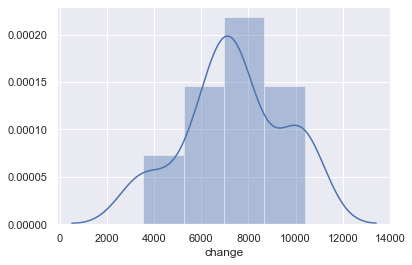

In [18]:
# In[27]:


sns.distplot(cluster_summary[cluster_summary['cluster']==cluster]['change'])

In [19]:
import geopandas as gpd

map_df = gpd.read_file("map.shp")
map_df.index = census.index

def highlight_constits(map_df,constits):
    ids = []
    for constit in constits:
        ids += [ onsid_from_name(constit,ge17) ]
    highlight_map = map_df
    highlight_map['color'] = 0.9
    L = len(ids)
    for i,id_ in enumerate(ids):
        highlight_map['color'][id_] = i*0.5/L 
    return highlight_map

In [20]:
constits = cluster_summary[cluster_summary['cluster']==cluster].sort_values(by='dist_from_mean',ascending=False)['constituency']
constits

104                    Reading East
106                         Watford
101    Chingford and Woodford Green
102                 Chipping Barnet
103              Enfield, Southgate
105      Uxbridge and South Ruislip
107                       Wimbledon
108        Wolverhampton South West
Name: constituency, dtype: object

/Users/robertsinclair/anaconda3/envs/democracy/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


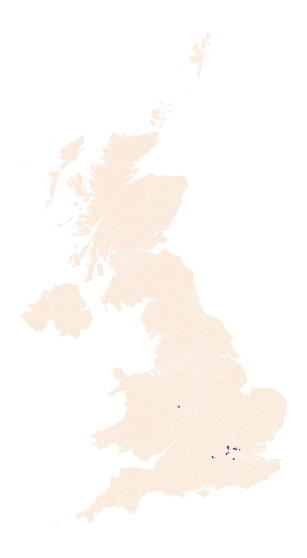

In [21]:
hmap = highlight_constits(map_df,constits)
f, ax = plt.subplots(1, figsize=(10, 10))
ax = hmap.plot(column=hmap['color'],ax=ax,linewidth=0.1)
ax.set_axis_off()

IndexError: index 0 is out of bounds for axis 0 with size 0

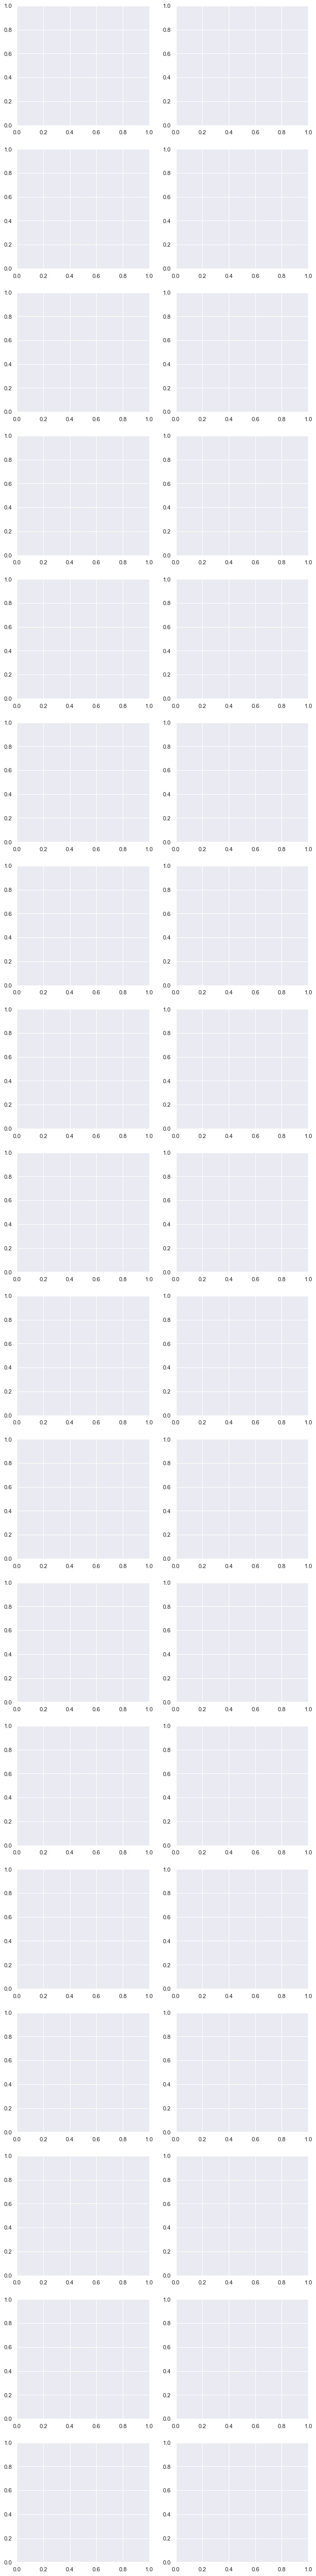

In [22]:
constits = 'Truro and Falmouth'
fig, ax = plt.subplots(len(constits),2,figsize=(10,5*len(constits)))

for i,constit in enumerate(constits):
    onsid = onsid_from_name(constit,ge17)
    #plt.figure(i)
    
    ge15[parties].loc[onsid].plot.bar(color=['r','b','y','m','g','y'],title=constit+'2015',ax=ax[i,0])
    
    ge17[parties].loc[onsid].plot.bar(color=['r','b','y','m','g','y'],title=constit+'2017',ax=ax[i,1])
    #sns.distplot(cluster_summary[cluster_summary['cluster']==i]['change'])

In [ ]:
constit_demog[constit_demog['Constituency'].isin(constits)]

In [ ]:
# Actual labour forcast/expected votes
# 
# How much money per constituency campaign 
# 
# Incumbency ???
# 
# House prices 
# 
# Local press 
# 
# How does marginal effect result?
# Dont ignore anomolies that aren't marginal 
# 
# Noise of model, ensemble results 